**Wireless Internet Project**

```
  Indoor fingerprint localization
    
*   Gioele Verze 10580742
*   Francesco Dolci 10611238 



```



 

In [ ]:
!apt-get install tshark
!pip install pyshark

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tshark is already the newest version (2.6.10-1~ubuntu18.04.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Retrieve from .pcap file timestamp, source address, ssid and rssi of each packet

In [ ]:
import os
import nest_asyncio
import pyshark
import pandas as pd
import numpy as np

nest_asyncio.apply()
cap = pyshark.FileCapture('sample_data/map.pcap')

TIMESTAMP = []
SA = []
SSID = []
RSSI = []

count = 0
successfull_packets = 0
for packet in cap:
  success = False
  count = count+1

  try:
      timestamp = packet.sniff_timestamp
      wlan_layers = packet.get_multiple_layers('wlan')
      sa = wlan_layers[0].sa
      ssid = wlan_layers[1].ssid
      rssi = packet.wlan_radio.signal_dbm
      success = True
  except:
    success = False

  if(success):
    successfull_packets = successfull_packets + 1
    TIMESTAMP.append(timestamp)
    SA.append(sa)
    SSID.append(ssid)
    RSSI.append(rssi)

print('Read: ', count)
print('Successfully processed:', successfull_packets)


Read:  620
Successfully processed: 620


In [ ]:
#show file retrieved before
df_cap = pd.DataFrame(list(zip(TIMESTAMP,SA,SSID,RSSI)), columns = ['Timestamp','SA','SSID','RSSI'])
display(df_cap)

,Timestamp,SA,SSID,RSSI
0,1656512875.025756000,b0:3e:51:09:93:62,SKYDB964,-64
1,1656512875.034606000,38:37:8b:18:ad:1f,WebPocket-AD1F,-86
2,1656512875.036600000,66:b3:fe:e2:cb:c2,OnePlus 5,-52
3,1656512875.037596000,3c:98:72:48:9b:1b,Verze,-73
4,1656512878.609959000,3c:98:72:48:9b:1d,Verze5G,-88
...,...,...,...,...
615,1656513305.786113000,14:8f:21:d3:b8:e5,ConnectedCAM2228,-80
616,1656513305.786769000,3c:98:72:48:9b:1b,Verze,-69
617,1656513305.787375000,00:22:6c:d2:87:8c,SSID:,-90
618,1656513305.791186000,34:cd:be:a7:fc:de,Speedport LTE - MSK7,-100


Create the fingerprint map by assigning the position value based on the timestamp (new position every 20 sec)

In [ ]:
def create_ground_truth(timestamp):
  interval=20
  time=1656512875
  zone=20
  for i in range(zone):
    if((float(timestamp)>time) & (float(timestamp)<time+interval)):
      return i
    time=time+interval

  return zone-1


In [ ]:
#show detections with relative zone
df_cap['gt'] = df_cap['Timestamp'].apply(create_ground_truth)
df_cap.to_csv('df_cap.csv')

display(df_cap)

,Timestamp,SA,SSID,RSSI,gt
0,1656512875.025756000,b0:3e:51:09:93:62,SKYDB964,-64,0
1,1656512875.034606000,38:37:8b:18:ad:1f,WebPocket-AD1F,-86,0
2,1656512875.036600000,66:b3:fe:e2:cb:c2,OnePlus 5,-52,0
3,1656512875.037596000,3c:98:72:48:9b:1b,Verze,-73,0
4,1656512878.609959000,3c:98:72:48:9b:1d,Verze5G,-88,0
...,...,...,...,...,...
615,1656513305.786113000,14:8f:21:d3:b8:e5,ConnectedCAM2228,-80,19
616,1656513305.786769000,3c:98:72:48:9b:1b,Verze,-69,19
617,1656513305.787375000,00:22:6c:d2:87:8c,SSID:,-90,19
618,1656513305.791186000,34:cd:be:a7:fc:de,Speedport LTE - MSK7,-100,19


Show all different SSID found through scanning procedure

In [ ]:
ssid=np.unique(df_cap['SSID'])
display(ssid)

array(['Andreola', 'ConnectedCAM2228', 'EOLO - FRITZ!Box 4020 LW',
       'EOLO - FRITZ!Box 7530 NP', 'EOLO - FRITZ!Box 7530 TV', 'MARISA65',
       'OnePlus 5', 'SKYDB964', 'SSID: ', 'Speedport LTE - MSK7',
       'TIM-18487105 ', 'TIM-20085789', 'TIM-51339330', 'TP-Link_E30A',
       'Verze', 'Verze5G', 'WWW.DIRETE.IT', 'WebPocket-AD1F',
       'WiFi Linksys', 'WiFi_F6DC34', 'Wifi_Casa'], dtype=object)

Create training data for the nn by averaging RSSI value for each different SSID corresponding to different point in the map

In [ ]:
zone=20

value=[]

for i in range(zone):
  
  cont=[0 for x in range(len(ssid))]       #numero di RSSI per SSID trovati
  SUM=[0 for x in range(len(ssid))]        #SUM di ogni RSSI per far la media
  RSSI=[0 for x in range(len(ssid))]       #RSSI medio

  for j in range(len(df_cap)):
    for x in range(len(ssid)):
      if df_cap.iloc[j,4]==i:
        if(df_cap.iloc[j,2]==ssid[x]):
          SUM[x]=SUM[x]-int(df_cap.iloc[j,3])
          cont[x]=cont[x]+1

  for x in range(len(ssid)):
    if cont[x]==0:
      RSSI[x]=(-100)
    else:
      RSSI[x]=(-SUM[x]/cont[x])

  value.append(RSSI[:])

#the index of the row corresponds to the zone
df_cap_RSSI = pd.DataFrame(value, columns =(ssid))
display(df_cap_RSSI)

,Andreola,ConnectedCAM2228,EOLO - FRITZ!Box 4020 LW,EOLO - FRITZ!Box 7530 NP,EOLO - FRITZ!Box 7530 TV,MARISA65,OnePlus 5,SKYDB964,SSID:,Speedport LTE - MSK7,...,TIM-20085789,TIM-51339330,TP-Link_E30A,Verze,Verze5G,WWW.DIRETE.IT,WebPocket-AD1F,WiFi Linksys,WiFi_F6DC34,Wifi_Casa
0,-100.0,-100.000000,-100.0,-100.0,-100.0,-100.00,-46.166667,-64.166667,-100.0,-100.0,...,-100.0,-100.0,-100.000000,-73.166667,-86.250000,-100.000000,-86.000000,-100.0,-100.00,-100.0
1,-100.0,-100.000000,-100.0,-100.0,-100.0,-100.00,-51.500000,-61.333333,-100.0,-100.0,...,-100.0,-92.0,-100.000000,-76.000000,-85.833333,-87.666667,-92.500000,-100.0,-100.00,-100.0
2,-100.0,-100.000000,-100.0,-100.0,-100.0,-100.00,-53.600000,-58.800000,-100.0,-100.0,...,-90.0,-100.0,-100.000000,-69.800000,-81.200000,-89.500000,-97.750000,-100.0,-100.00,-100.0
3,-100.0,-100.000000,-100.0,-100.0,-100.0,-100.00,-50.500000,-53.166667,-100.0,-100.0,...,-100.0,-100.0,-100.000000,-72.000000,-78.833333,-88.000000,-86.000000,-100.0,-100.00,-100.0
4,-100.0,-100.000000,-100.0,-100.0,-88.5,-100.00,-53.800000,-48.800000,-100.0,-100.0,...,-100.0,-90.0,-100.000000,-71.400000,-78.800000,-88.000000,-88.000000,-100.0,-100.00,-100.0
5,-100.0,-100.000000,-100.0,-100.0,-87.0,-100.00,-47.500000,-47.000000,-100.0,-100.0,...,-100.0,-100.0,-100.000000,-76.333333,-77.333333,-90.000000,-88.000000,-100.0,-86.00,-100.0
6,-100.0,-100.000000,-100.0,-100.0,-93.0,-100.00,-57.600000,-45.800000,-100.0,-100.0,...,-100.0,-100.0,-100.000000,-76.000000,-75.800000,-100.000000,-85.333333,-100.0,-86.75,-100.0
7,-100.0,-100.000000,-100.0,-100.0,-100.0,-100.00,-53.833333,-45.833333,-100.0,-100.0,...,-100.0,-100.0,-100.000000,-78.500000,-80.000000,-88.000000,-88.500000,-100.0,-92.00,-100.0
8,-100.0,-100.000000,-100.0,-100.0,-100.0,-100.00,-54.400000,-41.000000,-100.0,-100.0,...,-100.0,-100.0,-100.000000,-74.600000,-76.800000,-91.000000,-100.000000,-100.0,-96.25,-100.0
9,-100.0,-100.000000,-100.0,-100.0,-82.5,-100.00,-54.000000,-41.500000,-100.0,-100.0,...,-100.0,-100.0,-100.000000,-66.833333,-76.166667,-86.000000,-86.000000,-100.0,-95.00,-100.0


Create Test dataset by reading the csv file corresponding to the test scan. This script is used to create the file **test.csv**, a file that contains five row correspondig to the value of each test zone.

In [ ]:
#I have used 5 different file for each mesurement in different zone. 
#After averaging the mesurement to get 1 row with avg RSSI for 
#each file I have concatenate them to get the file 'test.csv'

#code to read value in zone1
file=pd.read_csv("sample_data/zona1.csv")
display(file)
misuration_zone=[[0.5,3],[3.5,2.5],[2.5,2.5],[2.5,1.8],[0.5,1.5]]
ssid_captured=np.unique(file['SSID'])
display(ssid_captured)

cont=[0 for x in range(len(ssid))]       #numero di RSSI per SSID trovati
SUM=[0 for x in range(len(ssid))]        #SUM di ogni RSSI per far la media
RSSI=[0 for x in range(len(ssid))]       #RSSI medio

for j in range(len(file)):
    for x in range(len(ssid)):
        if(file.iloc[j,3]==ssid[x]):
          SUM[x]=SUM[x]-int(file.iloc[j,4])
          cont[x]=cont[x]+1

for x in range(len(ssid)):
    if cont[x]==0:
      RSSI[x]=(-100)
    else:
      RSSI[x]=(-SUM[x]/cont[x])

#after averaging value concatenate with other zone




,Unnamed: 0,Timestamp,SA,SSID,RSSI
0,0,1.656516e+09,3c:98:72:48:9b:1d,Verze5G,-74
1,1,1.656516e+09,b0:3e:51:09:93:62,SKYDB964,-56
2,2,1.656516e+09,66:b3:fe:e2:cb:c2,OnePlus 5,-53
3,3,1.656516e+09,3c:98:72:48:9b:1b,Verze,-69
4,4,1.656516e+09,3c:98:72:48:9b:1d,Verze5G,-75
...,...,...,...,...,...
75,75,1.656516e+09,b0:3e:51:09:93:62,SKYDB964,-56
76,76,1.656516e+09,66:b3:fe:e2:cb:c2,OnePlus 5,-60
77,77,1.656516e+09,3c:98:72:48:9b:1b,Verze,-60
78,78,1.656516e+09,02:b7:09:21:b3:01,TIM-51339330,-91


array(['OnePlus 5', 'SKYDB964', 'TIM-20085789', 'TIM-51339330',
       'TP-Link_E30A', 'Verze', 'Verze5G', 'WWW.DIRETE.IT',
       'WebPocket-AD1F', 'WiFi-Jaafar'], dtype=object)

Function to map the position in coordinates, the distance between two consecutive points is, more or less, 1 meter



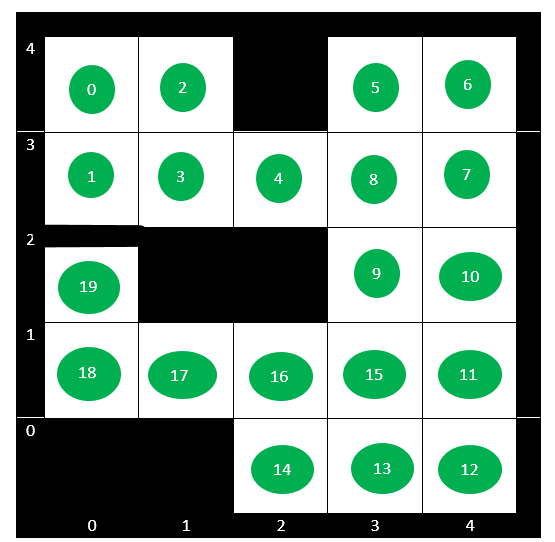

In [ ]:
def formatPosition(position):
    if(position==0):
      x=0.0
      y=4.0
    if(position==1):
      x=0.0
      y=3.0
    if(position==2):
      x=1.0
      y=4.0
    if(position==3):
      x=1.0
      y=3.0
    if(position==4):
      x=2.0
      y=3.0
    if(position==5):
      x=3.0
      y=4.0
    if(position==6):
      x=4.0
      y=4.0
    if(position==7):
      x=4.0
      y=3.0
    if(position==8):
      x=3.0
      y=3.0
    if(position==9):
      x=3.0
      y=2.0
    if(position==10):
      x=4.0
      y=2.0
    if(position==11):
      x=4.0
      y=1.0
    if(position==12):
      x=4.0
      y=0.0
    if(position==13):
      x=3.0
      y=0.0
    if(position==14):
      x=2.0
      y=0.0
    if(position==15):
      x=3.0
      y=1.0
    if(position==16):
      x=2.0
      y=1.0
    if(position==17):
      x=1.0
      y=1.0
    if(position==18):
      x=0.0
      y=1.0
    if(position==19):
      x=0.0
      y=2.0
    return x,y


In [ ]:
#array of fixed position used to show the map on the scatter plot
fixedPosition= [[2,0],
                [3,0],
                [4,0],
                [0,1],
                [1,1],
                [2,1],
                [3,1],
                [4,1],
                [0,2],
                [3,2],
                [4,2],
                [0,3],
                [1,3],
                [2,3],
                [3,3],
                [4,3],
                [0,4],
                [1,4],
                [3,4],
                [4,4],]             

fixedPosition=np.array(fixedPosition)

**KNN**

In the KNN positioning algorithm, the RSSI vector of a target location is individually compared with all the fingerprints in the radio map. The degree of matching between the RSS vector and the fingerprint is characterized by the Euclidean distance. The Euclidean distances between the target location and all the fingerprints in the ratio map are ranked in the ascending order. Subsequently, the average of the coordinates of the K reference points with the smallest distance is taken as the position of the target location.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['LayerFieldsContainer']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['LayerFieldsContainer']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['LayerFieldsContainer']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['LayerFieldsContainer']. An error will be raised in 1.2.
  FutureWarning,
/usr

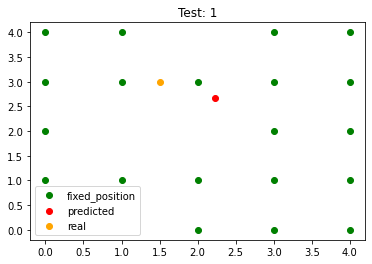

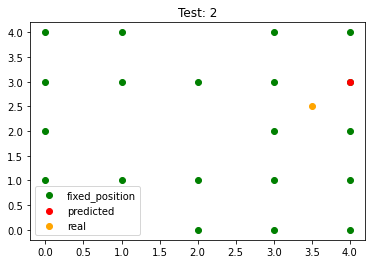

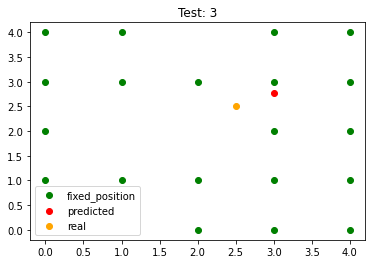

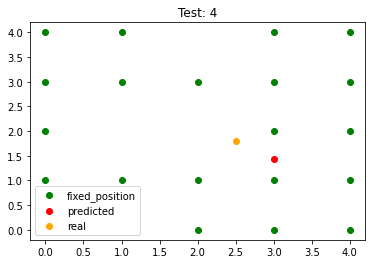

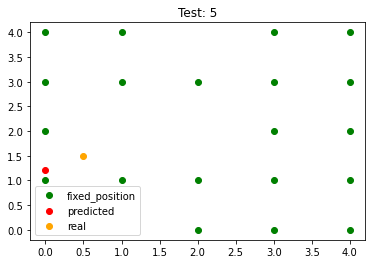

In [ ]:

from sklearn.neighbors import KNeighborsClassifier 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

      
#this cicle is used to map the position in coordinates
#the row index of train matrix corresponds to the zone
labels=[]
for i in range(zone):
  labels.append(formatPosition(i))

#upload the test file, value and position
file=pd.read_csv("sample_data/test.csv")
RSSI=file.drop('22',axis=1)
RSSI=RSSI.drop('21',axis=1)
real_position=np.array(file[['21','22']])

predicted_position=np.array([[0.0,0.0],[0.0,0.0],[0.0,0.0],[0.0,0.0],[0.0,0.0]])


for x in range(len(file)):

    predicted=[]
    for k in range(1,10):
      knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
      knn.fit(df_cap_RSSI, labels)
      prediction = knn.predict(np.array(RSSI)[x,range(1,22)].reshape(1,21))
      
      predicted.append(prediction)

    predicted=np.squeeze(np.array(predicted),axis=1)
    

    plt.figure(x)
    plt.title(f'Test: {x+1}')
    plt.scatter(fixedPosition[:,0],fixedPosition[:,1],c='green',label='fixed_position')
    plt.scatter(predicted[:,0].mean(),predicted[:,1].mean(),c='red',label='predicted')
    plt.scatter(real_position[x,0],real_position[x,1],c='orange',label='real')
    plt.legend()

    predicted_position[x,0]=predicted[:,0].mean()
    predicted_position[x,1]=predicted[:,1].mean()


In [ ]:

#average error in meters using KNN
#it is calculated by averaging the distance between real and predicted point
#it is in meters because each relevation is distante one meter

error=(np.sqrt(np.power(predicted_position[:,0]-real_position[:,0],2)+np.power(predicted_position[:,1]-real_position[:,1],2))).mean()
print(f'The average using KNN error is: {error} meters')

The average using KNN error is: 0.652006150671456 meters


**RANDOM FOREST**

The Random Forest method is an ensemble learning algorithm that builds and combines multiple decision trees to achieve highly accurate and stable predictions. In this case it takes in signal strenght from WiFi devices and uses it to train the model.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['LayerFieldsContainer']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['LayerFieldsContainer']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['LayerFieldsContainer']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['LayerFieldsContainer']. An error will be raised in 1.2.
  FutureWarning,
/usr

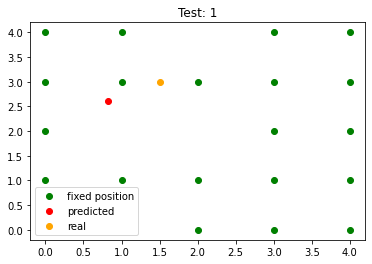

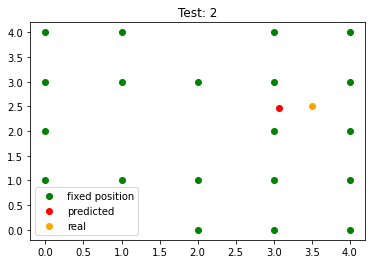

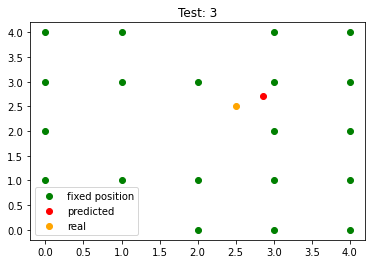

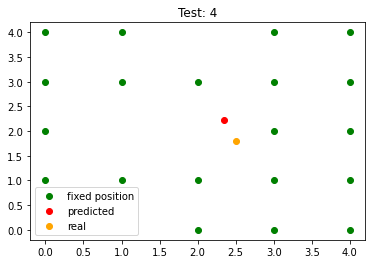

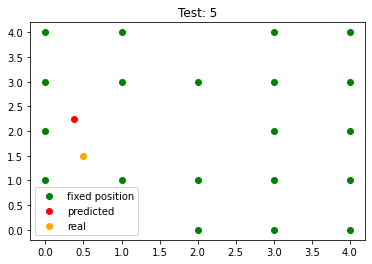

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#this cicle is used to map the position in coordinates
#the row index of train matrix corresponds to the zone
labels=[]
for i in range(zone):
  labels.append(formatPosition(i))

#upload the test file 
file=pd.read_csv("sample_data/test.csv")
RSSI=file.drop('22',axis=1)
RSSI=RSSI.drop('21',axis=1)
real_position=np.array(file[['21','22']])



predicted_position=np.array([[0.0,0.0],[0.0,0.0],[0.0,0.0],[0.0,0.0],[0.0,0.0]])

for x in range(len(file)):
    rf = RandomForestRegressor(n_estimators = 10000, random_state = 45)
    rf.fit(df_cap_RSSI,labels);

    predicted=rf.predict(np.array(RSSI)[x,range(1,22)].reshape(1,21))
    
    plt.figure(x)
    plt.title(f'Test: {x+1}')
    plt.scatter(fixedPosition[:,0],fixedPosition[:,1],c='green',label='fixed position')
    plt.scatter(predicted[:,0],predicted[:,1],c='red',label='predicted')
    plt.scatter(real_position[x,0],real_position[x,1],c='orange',label='real')
    plt.legend()

    
    predicted_position[x,0]=predicted[:,0]
    predicted_position[x,1]=predicted[:,1]



In [ ]:

#average error in meters using Random Forest
#it is calculated by averaging the distance between real and predicted point
#it is in meters because each relevation is distante one meter

error=(np.sqrt(np.power(predicted_position[:,0]-real_position[:,0],2)+np.power(predicted_position[:,1]-real_position[:,1],2))).mean()
print(f'The average using Random Forest error is: {error} meters')


The average using Random Forest error is: 0.5641005331079272 meters


CONCLUSION:

When the indoor positioning method based on KNN has a large positioning area and large fingerprint data, the online stage algorithm generally is subjected to a large amount of calculation and difficulty in improving the positioning accuracy. Random Forest works very well for large databases instead. The obtained values also depend on the number of present AP in the area and are affected by other factors including strong dependance on the environment (e.g. changes in the indoor environment can have sgnificant impact on indoor localization results). In particular, the strength of a WiFi signal is sentisitive to many factors, including stationary objects and moving people. These represent the main problems that could occur during the testing phase.